In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

from astropy import units as u
from astropy import constants as c
from astropy.modeling.models import BlackBody
from scipy.special import wofz, expn
from scipy.interpolate import interp1d
from scipy.integrate import trapz

from astro530 import NIntegrate, partition, saha_phi, P_e, Kc_total, K_NaD

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51'])

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:
A_table = pd.read_pickle('./data/abundances.pkl')
i_table = pd.read_pickle('./data/ionization.pkl')
u_table = pd.read_pickle('./data/partition.pkl')

In [4]:
def opacity(l, T, Pg, Pe, nH, rho, micro):
    K = Kc_total(l, T, Pg, Pe)
    for i in range(1, 3):
        K += K_NaD(l, T, Pg, Pe, nH, rho, micro, i).cgs
    return K

In [5]:
VALIIIC = pd.read_pickle('./data/VALIIIC_atm.pkl')

In [6]:
tau_500 = VALIIIC['tau_500'].to_numpy()

h = VALIIIC['h'].to_numpy() * u.km
s = h[0] - h

T = VALIIIC['T'].to_numpy() * u.K

micro = VALIIIC['V'].to_numpy() * u.km/u.s

nH = VALIIIC['n_H'].to_numpy() * u.cm**-3

ne = VALIIIC['n_e'].to_numpy() * u.cm**-3
Pe = ne * c.k_B * T

Pg = VALIIIC['Pgas/Ptotal'].to_numpy() * VALIIIC['Ptotal'].to_numpy() * u.barye

rho = VALIIIC['rho'].to_numpy() * u.g/u.cm**3

In [7]:
def tau_fn(l):
    K = opacity(l, T, Pg, Pe, nH, rho, micro)
    tau = np.array([trapz(K[:i+1] * rho[:i+1], s[:i+1]) for i in range(len(s))])
    return tau

In [27]:
D_lines = np.array([5895.932, 5889.959]) * u.AA

wvlen_coarse = np.linspace(5884, 5901, 100) 
wvlen_D = np.concatenate([np.linspace(5889.75, 5890.15), np.linspace(5895.75, 5896.10)])

wvlen = np.sort(np.array([wvlen_coarse, wvlen_D]).flatten()) * u.AA

<ipython-input-104-868590ceab15>:5: RuntimeWarning: divide by zero encountered in log10
  tau_D1 = np.log10(tau_fn(D_lines[0]))
<ipython-input-104-868590ceab15>:6: RuntimeWarning: divide by zero encountered in log10
  tau_D2 = np.log10(tau_fn(D_lines[1]))
<ipython-input-104-868590ceab15>:7: RuntimeWarning: divide by zero encountered in log10
  tau_wing = np.log10(tau_fn(wing))
<ipython-input-104-868590ceab15>:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(tau_500), tau_D2, color= 'C1', label=r'Na D$_2$ line center')
<ipython-input-104-868590ceab15>:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(tau_500), tau_D1, color ='C3', label=r'Na D$_1$ line center')
<ipython-input-104-868590ceab15>:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(tau_500), tau_wing, color = 'C0', ls=':', label=r'far wing')


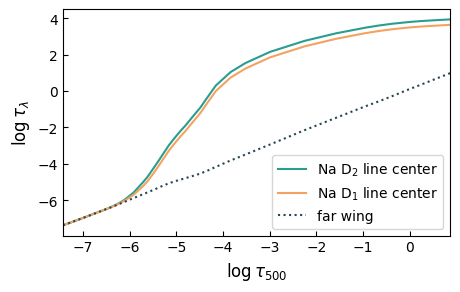

In [104]:
plt.figure(figsize=(5, 3), dpi=100)

wing = 5885 * u.AA

tau_D1 = np.log10(tau_fn(D_lines[0]))
tau_D2 = np.log10(tau_fn(D_lines[1]))
tau_wing = np.log10(tau_fn(wing))
plt.plot(np.log10(tau_500), tau_D2, color= 'C1', label=r'Na D$_2$ line center')
plt.plot(np.log10(tau_500), tau_D1, color ='C3', label=r'Na D$_1$ line center')
plt.plot(np.log10(tau_500), tau_wing, color = 'C0', ls=':', label=r'far wing')

plt.xlabel(r'$\log \tau_{500}$')
plt.ylabel(r'$\log \tau_\lambda$')
plt.legend()

plt.savefig('2tau.png', bbox_inches='tight')

In [29]:
def format_sn(x):
    e_str = '{:.1e}'.format(x)
    a = e_str.split('e')[0]
    b = int(e_str.split('e')[-1])
    return a + r'$\times 10^{' +str(b)+ '}$'

In [30]:
tau_lambda = np.array([tau_fn(wvlen[i]) for i in range(len(wvlen))])

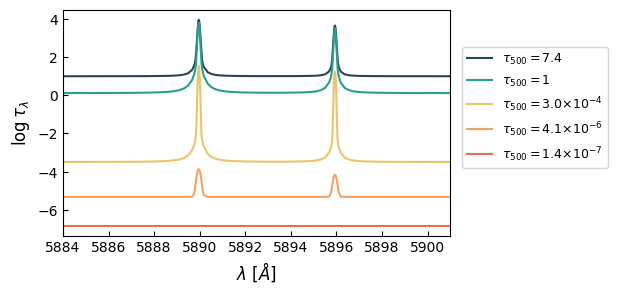

In [105]:
plt.figure(figsize=(5, 3),dpi=100)

plt.plot(wvlen, np.log10(tau_lambda[:, 51]), label=r'$\tau_{500} ='+'{:.1f}$'.format(tau_500[51]) )
plt.plot(wvlen, np.log10(tau_lambda[:, 48]), label=r'$\tau_{500} =' +'{:.0f}$'.format(tau_500[48]) )
plt.plot(wvlen, np.log10(tau_lambda[:, 41]), label=r'$\tau_{500} =$'+ format_sn(tau_500[41]))
plt.plot(wvlen, np.log10(tau_lambda[:, 30]), label=r'$\tau_{500} =$'+ format_sn(tau_500[30]))
plt.plot(wvlen, np.log10(tau_lambda[:, 10]), label=r'$\tau_{500} =$'+ format_sn(tau_500[10]))

plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$\log \tau_\lambda$')
plt.legend(fontsize=9, loc = [1.03,0.3])
plt.savefig('tau_wv.png', bbox_inches='tight')

In [32]:
def B_tau(wv, tau, T):
    Bs = [BlackBody(T[i]) for i in range(len(T))]                     
    S = u.Quantity([B(wv) for B in Bs])
    S_tau = interp1d(tau, S) 
    return S_tau

def F_nu(wv, T):
    H = np.zeros_like(wv.value)
    for i in range(len(wv)):
        tau = tau_fn(wv[i])  
        
        t = np.concatenate([np.logspace(-18, -2, 1000), np.logspace(-2, np.log10(np.max(tau)) - 0.5, 50)])
        
        S_tau = B_tau(wv[i], tau, T)
        
        y = 1/2 * S_tau(t) * expn(2, t)
        H[i] = trapz(y, t)                 
    flux = H * (4 * np.pi * u.sr)
    return flux

In [33]:
F = F_nu(wvlen, T)

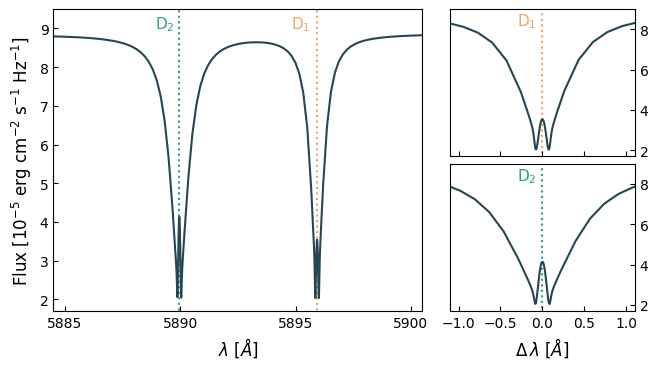

In [103]:
fig = plt.figure(dpi = 100, figsize = (7.5,4))
gs = GridSpec(2, 2, width_ratios=(2, 1), wspace =0.1, hspace=0.05, figure = fig)

ax1 = plt.subplot(gs[:, 0])
ax1.plot(wvlen, F * 10**5, c='C0')
ax1.set_xlim(5884.5, 5900.5)
ax1.set_xticks([5885, 5890, 5895, 5900])
ax1.vlines(D_lines, 1, 10, zorder=0, ls=':', color =['C3','C1'])
ax1.text(5894.8, 9, 'D$_1$',c='C3', size=11)
ax1.text(5888.9, 9, 'D$_2$',c='C1', size=11)
ax1.set_ylim(1.7, 9.5)

ax1.set_ylabel(r'Flux $[10^{-5}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}]$')
ax1.set_xlabel(r'$\lambda$ [$\AA$]')


ax2 = plt.subplot(gs[0, 1])
ax2.text(-0.3, 8.2, 'D$_1$',c='C3', size=11)

ax2.plot(wvlen - D_lines[0], F * 1e5, c='C0')
ax2.vlines(0, 1, 10, zorder=0, ls=':', color ='C3')

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(1.7, 9)

ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
ax2.yaxis.tick_right()
ax2.tick_params(labelbottom=False)

ax3 = plt.subplot(gs[1, 1])
ax3.text(-0.3, 8.2, 'D$_2$',c='C1', size=11)

ax3.plot(wvlen - D_lines[1], F * 1e5, c='C0')
ax3.vlines(0, 1, 10, zorder=0, ls=':', color = 'C1')

ax3.set_xlim(-1.1, 1.1)
ax3.set_ylim(1.7, 9)

ax3.set_xlabel(r'$\Delta\, \lambda\ [\AA]$')

ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
ax3.yaxis.tick_right()
plt.savefig('sodium_doublet_v1.png',bbox_inches = 'tight')

Text(0.5, 0, '$\\lambda$ [$\\AA$]')

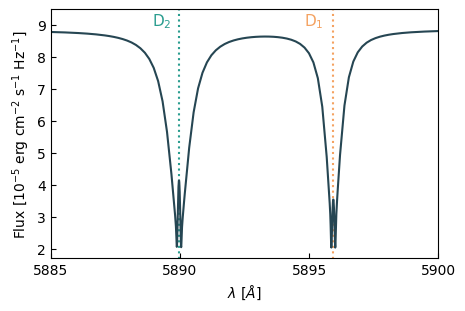

In [63]:
fig = plt.figure(dpi = 100, figsize = (5,3.3))

plt.plot(wvlen, F * 10**5, c='C0')
plt.xlim(5885, 5900)
plt.xticks([5885, 5890, 5895, 5900])
plt.vlines(D_lines, 1, 10, zorder=0, ls=':', color =['C3','C1'])
plt.text(5894.8, 9, 'D$_1$',c='C3', size=11)
plt.text(5888.9, 9, 'D$_2$',c='C1', size=11)
plt.ylim(1.7, 9.5)

plt.ylabel(r'Flux $[10^{-5}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}]$')
plt.xlabel(r'$\lambda$ [$\AA$]')

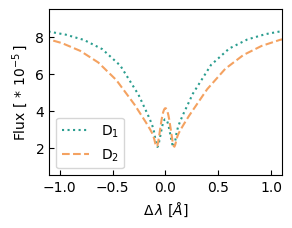

In [81]:
fig = plt.figure(dpi = 100, figsize = (3,2.2))

plt.plot(wvlen - D_lines[0], F * 1e5, 'C1:', label='D$_1$')

plt.plot(wvlen - D_lines[1], F * 1e5, 'C3--', label='D$_2$')

plt.xlim(-1.1, 1.1)
plt.ylim(0.5, 9.5)

plt.xlabel(r'$\Delta\, \lambda\ [\AA]$')
plt.ylabel(r'Flux $[\, * \, 10^{-5}\,]$')

plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.legend(fontsize=10)
plt.savefig('Na_Ds_v1.png',bbox_inches = 'tight')